In [1]:
from montecarlo import MonteCarlo
from CIRModel import BasicCIRModel
from ECIRModel import ECIRModel
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
def read_data(years):
    z = pd.read_csv('zero_coupon_yields_'+str(years)+'.csv')
    z = z.set_index('DATE')
    z = z.loc['2018-12-15':'2023-12-14']
    return z

z = pd.DataFrame()
years = [1, 2, 3, 5, 7, 10, 20, 30]

for i in years:
    z[i] = read_data(i)
    z[i] = z[i].replace('.', np.nan)
    z[i] = pd.to_numeric(z[i])

z = z.dropna()

In [3]:
def create_model(mod, data):
    models = []
    for i in data:
        models.append(MonteCarlo(mod, data[i][0]/100, int(i), 365*int(i), 100))

    return models

In [4]:
# Assuming you already have the BasicCIRModel defined correctly
cir = create_model(BasicCIRModel(0.3, 0.04, 3), z)

# Updated ECIRModel instantiation with all parameters
ecir = create_model(ECIRModel(kappa=0.01227, mu_r=0.09854, sigma=0.09395, r=66, p=0.3049, mu=0.002995, gamma=0.002321), z)


/var/folders/xw/z6_zcc7n7874ly2ljw7m9dk800ddy1/T/ipykernel_24027/2746386555.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  models.append(MonteCarlo(mod, data[i][0]/100, int(i), 365*int(i), 100))


In [5]:
prices_cir = pd.DataFrame()
for model in cir:
    prices_cir[model] = model.price_estimates()[2]

prices_cir.columns = years

In [6]:
prices_ecir = pd.DataFrame()
for model in ecir:
    prices_ecir[model] = model.price_estimates()[2]

prices_ecir.columns = years

In [7]:
prices = pd.concat([prices_cir, prices_ecir], axis = 1)
prices = prices.sort_index(axis = 1)
cols = ['1_CIR', '1_ECIR', '2_CIR', '2_ECIR', '3_CIR', '3_ECIR', '5_CIR', '5_ECIR', '7_CIR', '7_ECIR','10_CIR', '10_ECIR', '20_CIR', '20_ECIR', '30_CIR', '30_ECIR']
prices.columns = cols

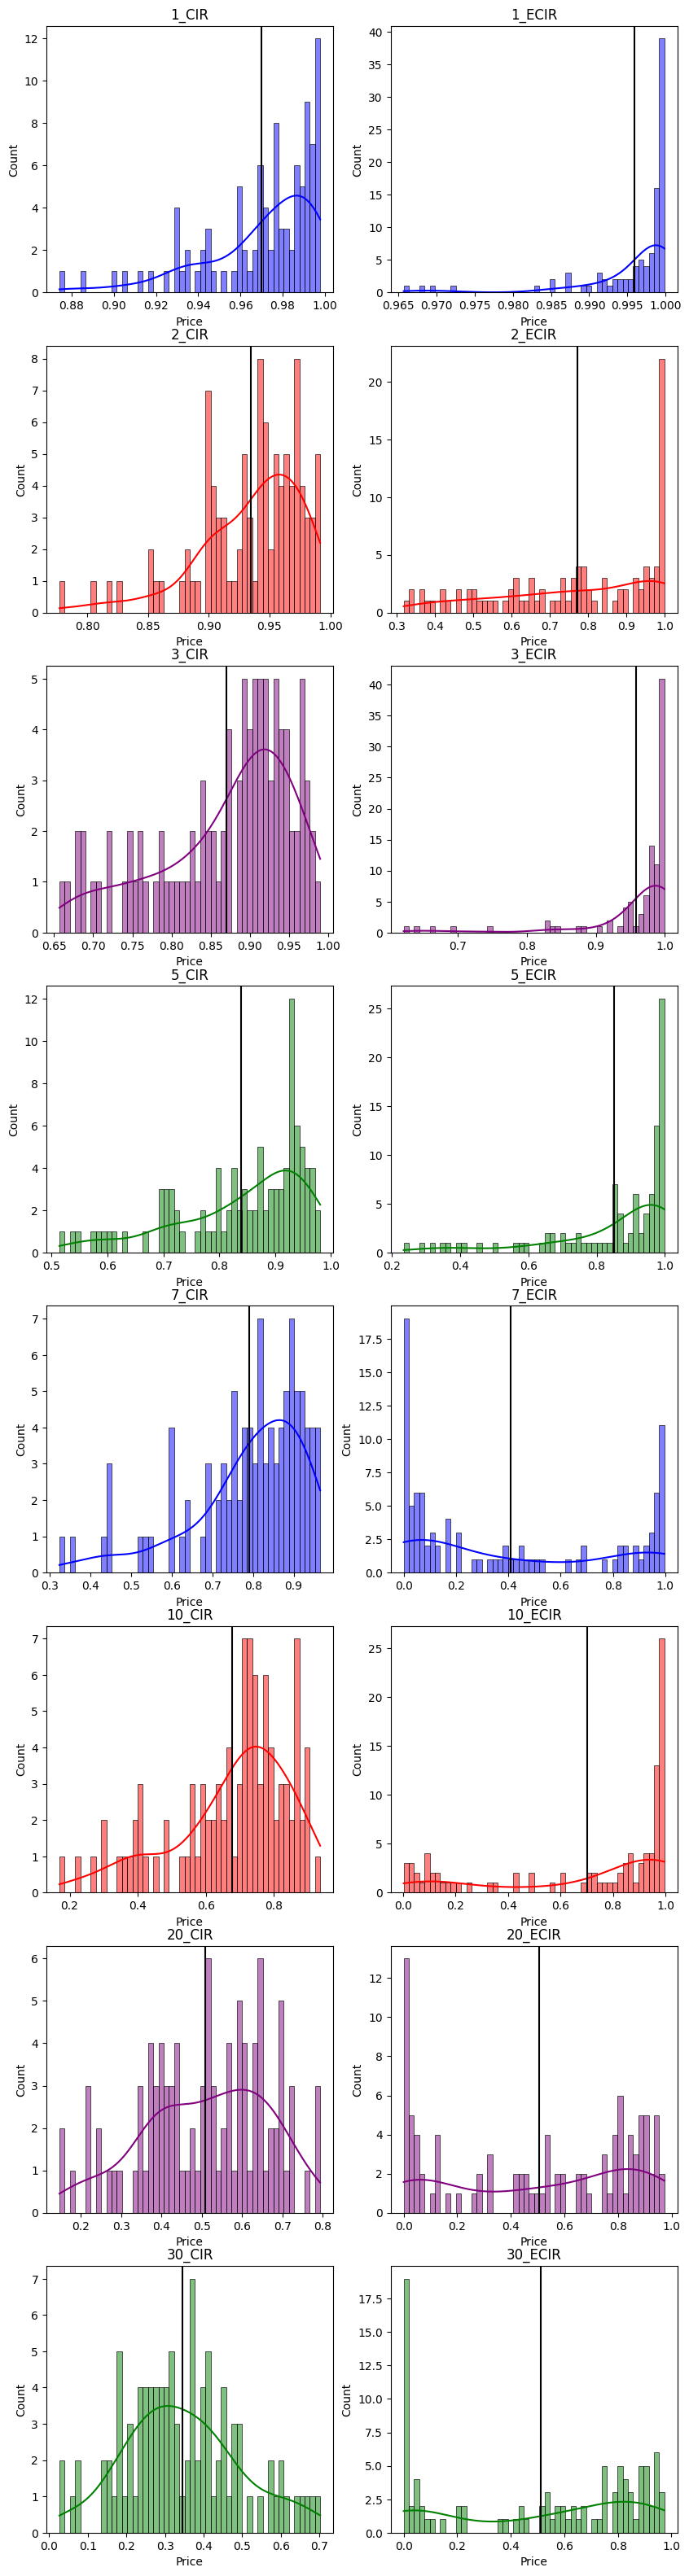

In [8]:
colors = ['blue', 'blue', 'red', 'red', 'purple', 'purple', 'green', 'green']*2

plt.figure(figsize = (10, 40))
for i in range(len(prices.columns)):
    plt.subplot(8, 2, i+1)
    plt.title(prices.columns.to_list()[i])
    sns.histplot(prices[cols[i]], color = colors[i], bins = 50, kde = True)
    plt.xlabel('Price')
    plt.axvline(np.mean(prices[cols[i]]), color = 'black')



In [9]:
avg_cir = []
err_cir = []
for col in prices_cir:
    avg_cir.append(np.mean(prices_cir[col]))
    err_cir.append(np.std(prices_cir[col]))

avg_ecir = []
err_ecir = []
for col in prices_ecir:
    avg_ecir.append(np.mean(prices_ecir[col]))
    err_ecir.append(np.std(prices_ecir[col]))

Text(0, 0.5, 'Price')

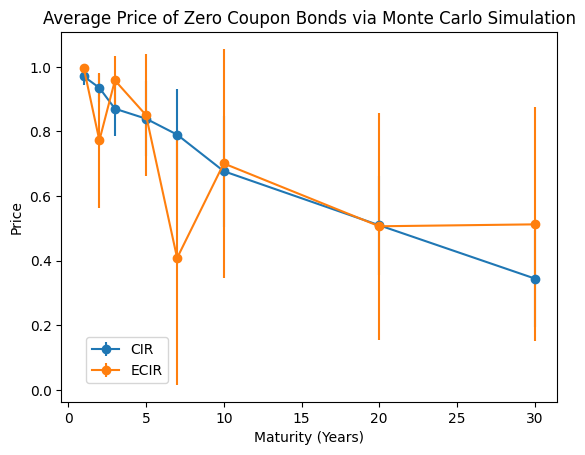

In [10]:
plt.errorbar(years, avg_cir, yerr = err_cir, label = 'CIR', marker = 'o')
plt.errorbar(years, avg_ecir, yerr = err_ecir, label = 'ECIR', marker = 'o')
plt.legend(loc = (0.05, 0.05))
plt.title('Average Price of Zero Coupon Bonds via Monte Carlo Simulation')
plt.xlabel('Maturity (Years)')
plt.ylabel('Price')

In [11]:
cir_paths = pd.DataFrame()

for i in range(len(cir)):
    cir_paths[years[i]] = cir[i].paths()

In [12]:
ecir_paths = pd.DataFrame()

for i in range(len(ecir)):
    ecir_paths[years[i]] = ecir[i].paths()

In [13]:
paths = pd.concat([cir_paths, ecir_paths], axis = 1)
paths = paths.sort_index(axis = 1)
cols = ['1_CIR', '1_ECIR', '2_CIR', '2_ECIR', '3_CIR', '3_ECIR', '5_CIR', '5_ECIR', '7_CIR', '7_ECIR','10_CIR', '10_ECIR', '20_CIR', '20_ECIR', '30_CIR', '30_ECIR']
paths.columns = cols

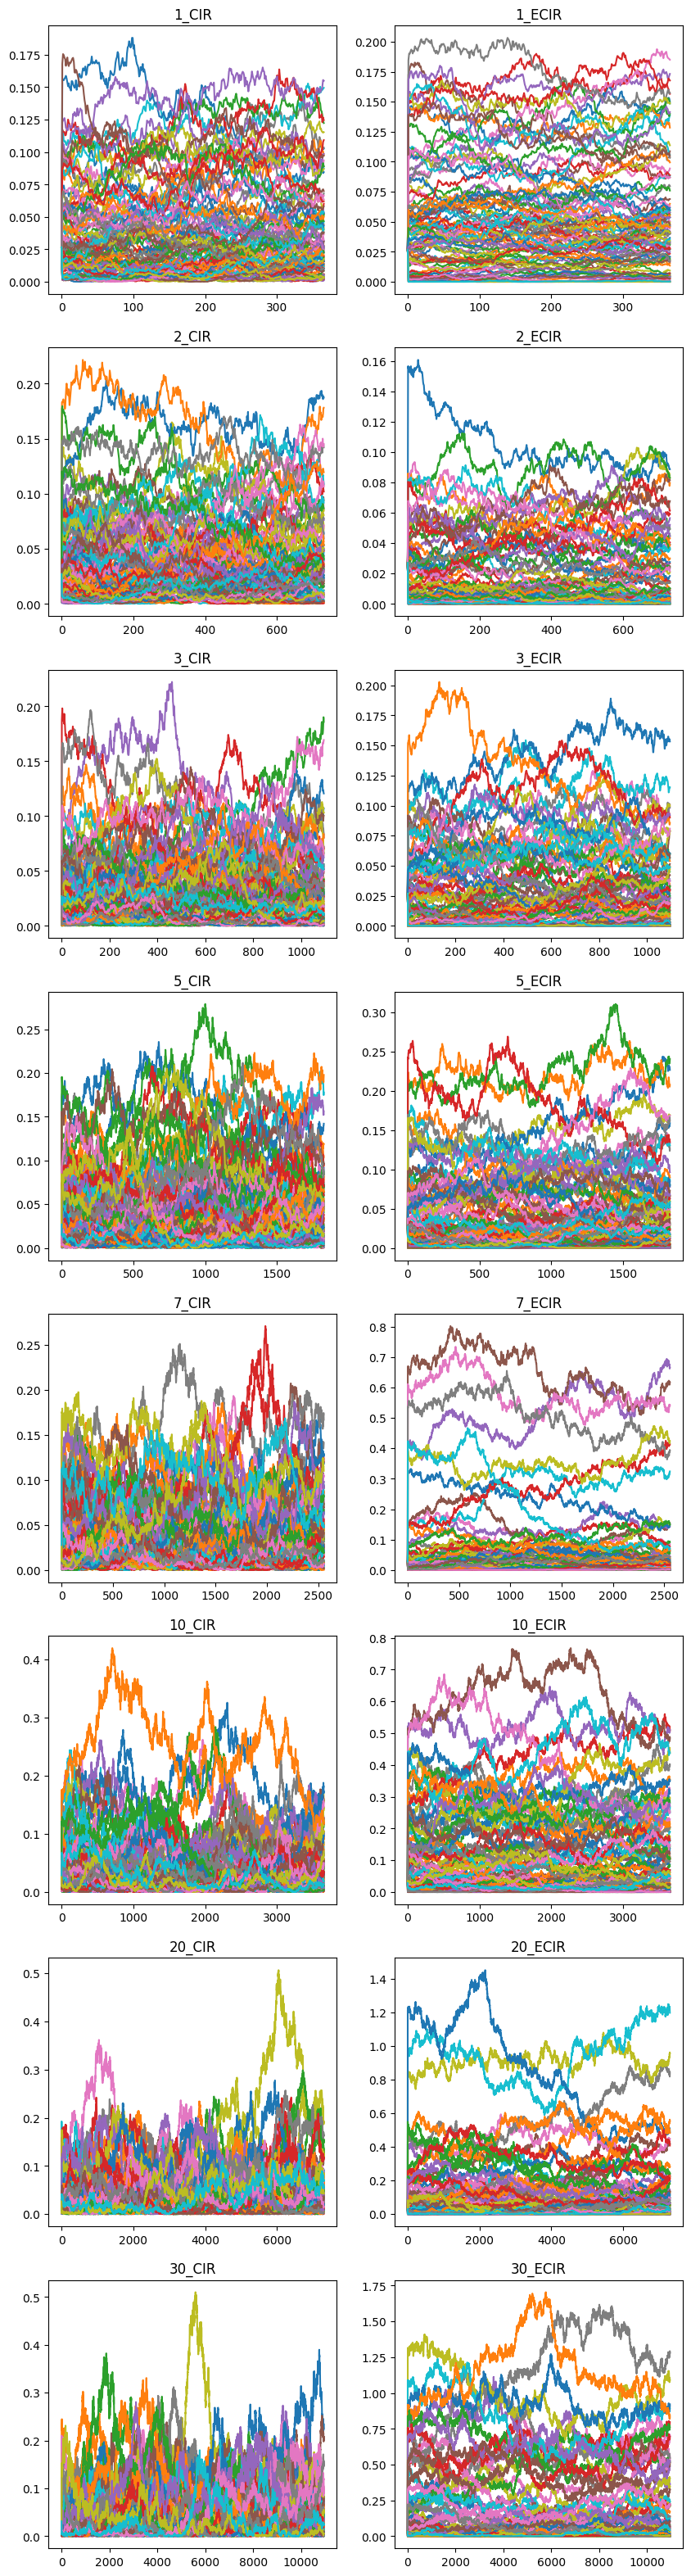

In [14]:
plt.figure(figsize = (10, 40))
for i in range(len(cols)):
    plt.subplot(8, 2, i+1)
    plt.title(cols[i])
    for j in range(len(paths[cols[i]])):
        plt.plot(np.arange(0, len(paths[cols[i]][j])), paths[cols[i]][j])

In [15]:
term = pd.DataFrame()
for i in range(len(cols)):
    term_val = []
    for j in range(len(paths[cols[i]])):
        term_val.append(paths[cols[i]][j][-1])
    term[cols[i]] = term_val

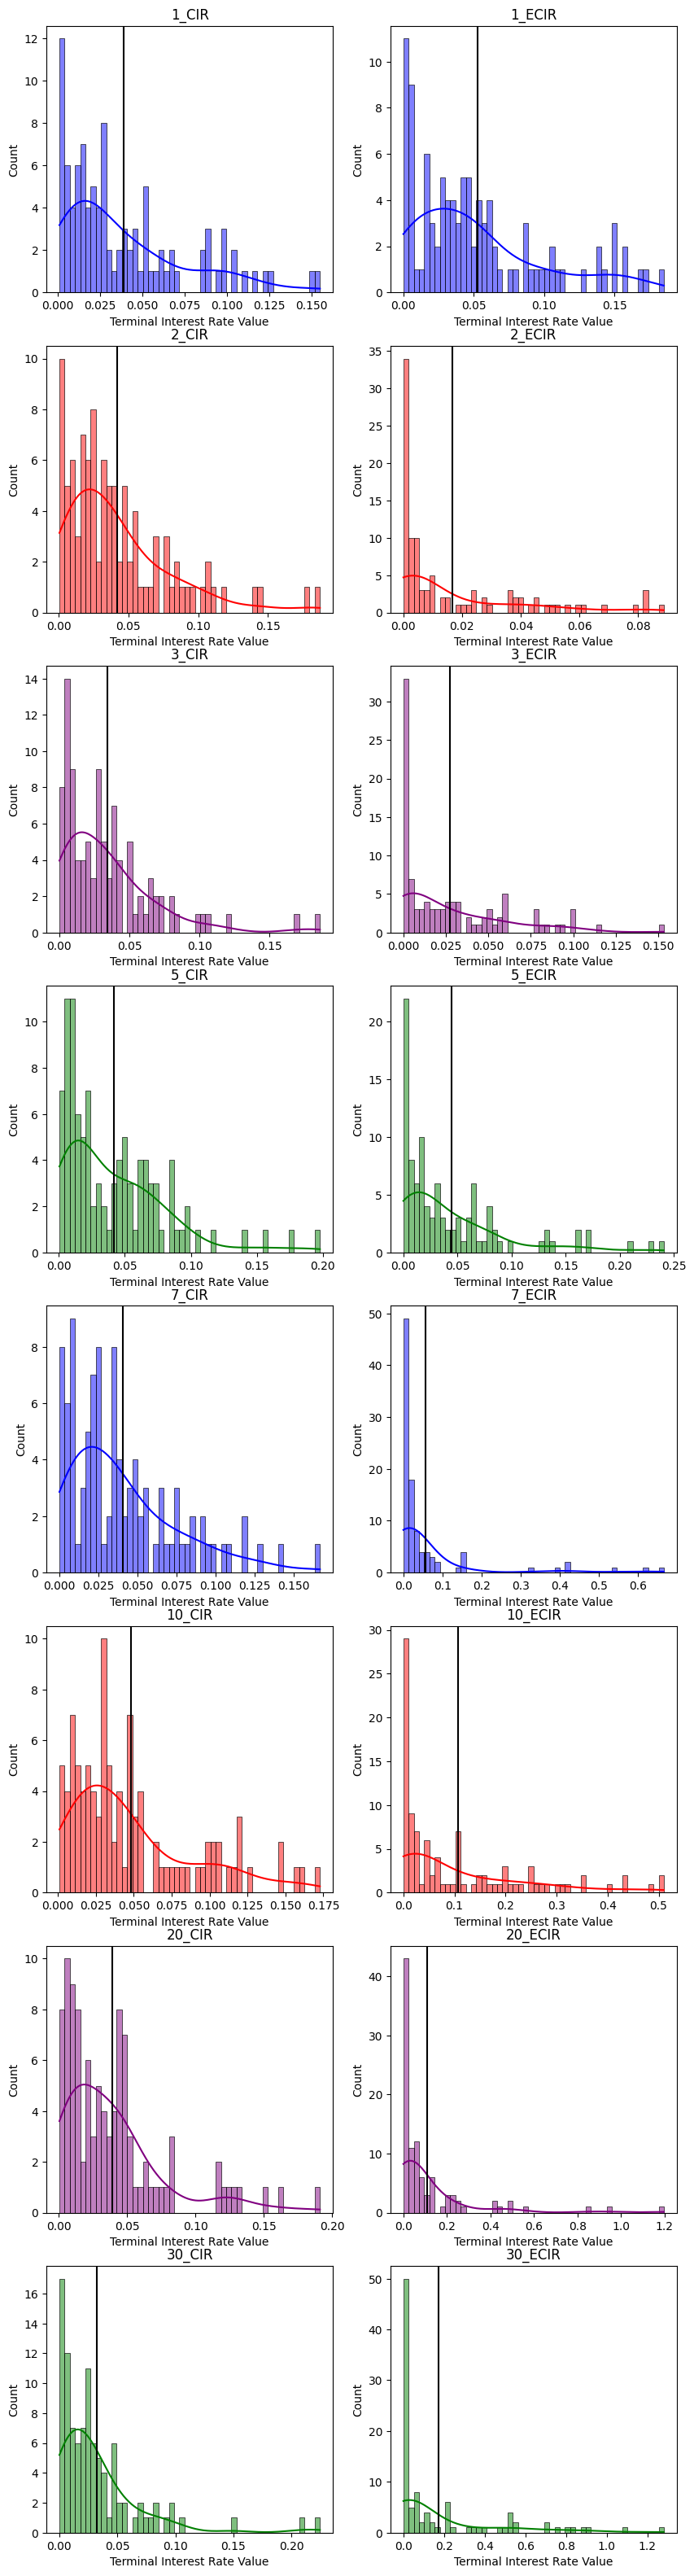

In [16]:
plt.figure(figsize = (10, 40))
for i in range(len(cols)):
    plt.subplot(8, 2, i+1)
    plt.title(cols[i])
    sns.histplot(term[cols[i]], color = colors[i], bins = 50, kde = True)
    plt.xlabel('Terminal Interest Rate Value')
    plt.axvline(np.mean(term[cols[i]]), color = 'black')

In [17]:
term_cir = pd.DataFrame()
term_ecir = pd.DataFrame()
for i in range(len(cols)):
    if i%2 == 0:
        term_cir[cols[i]]  = term[cols[i]]
    else:
        term_ecir[cols[i]] = term[cols[i]]

In [18]:
avg_cir_term = []
err_cir_term = []
for col in term_cir:
    avg_cir_term.append(np.mean(term_cir[col]))
    err_cir_term.append(np.std(term_cir[col]))

avg_ecir_term = []
err_ecir_term = []
for col in term_ecir:
    avg_ecir_term.append(np.mean(term_ecir[col]))
    err_ecir_term.append(np.std(term_ecir[col]))

Text(0, 0.5, 'Terminal Value of Interest Rate')

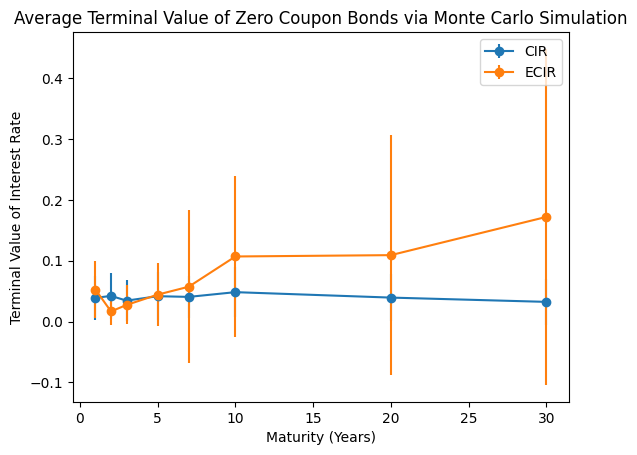

In [19]:
plt.errorbar(years, avg_cir_term, yerr = err_cir_term, label = 'CIR', marker = 'o')
plt.errorbar(years, avg_ecir_term, yerr = err_ecir_term, label = 'ECIR', marker = 'o')
plt.legend()
plt.title('Average Terminal Value of Zero Coupon Bonds via Monte Carlo Simulation')
plt.xlabel('Maturity (Years)')
plt.ylabel('Terminal Value of Interest Rate')

## Standard Deviation- Yield Rates Estimates

In [20]:
import pandas as pd

# Define maturities and model names based on your provided list
maturities = ['1Y', '2Y', '3Y', '5Y', '7Y', '10Y', '20Y', '30Y']
model_names = ['CIR', 'ECIR']

# Prepare data for DataFrame with zeros, to be replaced by actual standard deviations
data = {maturity: [0] * len(model_names) for maturity in maturities}
sd_df = pd.DataFrame(data, index=model_names)

# Populate the DataFrame with standard deviations for CIR and ECIR
for i, col in enumerate(term_cir.columns):
    # Assuming term_cir columns are ordered by maturity as '1', '2', '3', ..., '30'
    maturity = maturities[i]  # Convert numerical index to maturity string
    sd_df.loc['CIR', maturity] = term_cir[col].std()  # Insert CIR std dev

for i, col in enumerate(term_ecir.columns):
    # Assuming term_ecir columns are ordered by maturity as '1', '2', '3', ..., '30'
    maturity = maturities[i]  # Convert numerical index to maturity string
    sd_df.loc['ECIR', maturity] = term_ecir[col].std()  # Insert ECIR std dev

# The resulting DataFrame has models as index and maturities as columns
print(sd_df)


            1Y        2Y        3Y        5Y        7Y       10Y       20Y  \
CIR   0.036291  0.038293  0.033687  0.039287  0.034985  0.041076  0.038238   
ECIR  0.047342  0.023146  0.032304  0.052665  0.126333  0.132358  0.199007   

           30Y  
CIR   0.038299  
ECIR  0.277843  


/var/folders/xw/z6_zcc7n7874ly2ljw7m9dk800ddy1/T/ipykernel_24027/4188028806.py:15: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.03629128813240238' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  sd_df.loc['CIR', maturity] = term_cir[col].std()  # Insert CIR std dev
/var/folders/xw/z6_zcc7n7874ly2ljw7m9dk800ddy1/T/ipykernel_24027/4188028806.py:15: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.03829304945071528' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  sd_df.loc['CIR', maturity] = term_cir[col].std()  # Insert CIR std dev
/var/folders/xw/z6_zcc7n7874ly2ljw7m9dk800ddy1/T/ipykernel_24027/4188028806.py:15: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.

## Standard Deviation——Bond Price Estimates

In [21]:
import pandas as pd

# Define maturities and model names based on your provided list
maturities = ['1Y', '2Y', '3Y', '5Y', '7Y', '10Y', '20Y', '30Y']
model_names = ['CIR', 'ECIR']

# Prepare data for DataFrame with zeros, to be replaced by actual standard deviations
data = {maturity: [0] * len(model_names) for maturity in maturities}
sd_df = pd.DataFrame(data, index=model_names)

# Populate the DataFrame with standard deviations for CIR and ECIR
for i, col in enumerate(prices_cir.columns):
    # Assuming term_cir columns are ordered by maturity as '1', '2', '3', ..., '30'
    maturity = maturities[i]  # Convert numerical index to maturity string
    sd_df.loc['CIR', maturity] = prices_cir[col].std()  # Insert CIR std dev

for i, col in enumerate(prices_ecir.columns):
    # Assuming term_ecir columns are ordered by maturity as '1', '2', '3', ..., '30'
    maturity = maturities[i]  # Convert numerical index to maturity string
    sd_df.loc['ECIR', maturity] =prices_ecir[col].std()  # Insert ECIR std dev

# The resulting DataFrame has models as index and maturities as columns
print(sd_df)


            1Y        2Y        3Y        5Y        7Y       10Y       20Y  \
CIR   0.026856  0.043410  0.086039  0.115896  0.142431  0.172454  0.154515   
ECIR  0.006713  0.208597  0.076213  0.189926  0.394776  0.356292  0.353483   

           30Y  
CIR   0.149428  
ECIR  0.363859  


/var/folders/xw/z6_zcc7n7874ly2ljw7m9dk800ddy1/T/ipykernel_24027/2687707075.py:15: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.02685623171380199' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  sd_df.loc['CIR', maturity] = prices_cir[col].std()  # Insert CIR std dev
/var/folders/xw/z6_zcc7n7874ly2ljw7m9dk800ddy1/T/ipykernel_24027/2687707075.py:15: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.0434098044312406' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  sd_df.loc['CIR', maturity] = prices_cir[col].std()  # Insert CIR std dev
/var/folders/xw/z6_zcc7n7874ly2ljw7m9dk800ddy1/T/ipykernel_24027/2687707075.py:15: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 

## Mean Absolute Error-Yield Rates

In [22]:

df = pd.read_csv('DGS_30.csv')

# Extract the relevant columns for the specified maturities
maturities = ['DGS1', 'DGS2', 'DGS3', 'DGS5', 'DGS7', 'DGS10', 'DGS20', 'DGS30']
actual_rates_selected = df[maturities]

# Calculate the average rate for each maturity to use as actual rates
actual_rates_mean = 0.1*actual_rates_selected.mean()
estimated_rates_cir=term_cir.mean()
estimated_rates_ecir=term_ecir.mean()


# Rename the columns of the estimated rates DataFrames to match the actual rates DataFrame for direct comparison
estimated_rates_cir.index = ['DGS' + idx.split('_')[0] for idx in estimated_rates_cir.index]
estimated_rates_ecir.index = ['DGS' + idx.split('_')[0] for idx in estimated_rates_ecir.index]

# Calculate the MAE for each term
mae_rates_cir = abs(actual_rates_mean - estimated_rates_cir)
mae_rates_ecir = abs(actual_rates_mean - estimated_rates_ecir)

# Create a DataFrame to display the MAE for each term for CIR and ECIR models
mae_rates_df = pd.DataFrame({'CIR': mae_rates_cir, 'ECIR': mae_rates_ecir})

# Transpose the DataFrame so that models are in rows and terms are in columns
mae_rates_df = mae_rates_df.T

# Ensure the column names match the original maturities list for display
mae_rates_df.columns = ['DGS1', 'DGS2', 'DGS3', 'DGS5', 'DGS7', 'DGS10', 'DGS20', 'DGS30']

# Display the DataFrame
mae_rates_df


,DGS1,DGS2,DGS3,DGS5,DGS7,DGS10,DGS20,DGS30
CIR,0.374743,0.402672,0.429574,0.455283,0.482990,0.493971,0.521613,0.552626
ECIR,0.361019,0.428198,0.436678,0.452729,0.466252,0.435263,0.451763,0.412840


## Mean Absolute Error-Bond Price

In [25]:
import pandas as pd
import numpy as np

# Load data from a CSV file
df = pd.read_csv('DGS_30.csv')

# Select the relevant columns
maturities = ['DGS1', 'DGS2', 'DGS3', 'DGS5', 'DGS7', 'DGS10', 'DGS20', 'DGS30']
actual_rates_selected = df[maturities]

# Calculate the average interest rate for each maturity
actual_rates_mean = 0.1 * actual_rates_selected.mean()

# Assume a face value for the bonds
face_value = 100
# Define actual years to maturity
years_to_maturity = [1, 2, 3, 5, 7, 10, 20, 30]

# Calculate bond prices using actual interest rates
actual_bond_prices = face_value / ((1 + actual_rates_mean / 100) ** years_to_maturity)

# Assuming estimated_rates_cir and estimated_rates_ecir are Series with matching indices
estimated_bond_prices_cir = face_value / ((1 + estimated_rates_cir / 100) ** years_to_maturity)
estimated_bond_prices_ecir = face_value / ((1 + estimated_rates_ecir / 100) ** years_to_maturity)

# Calculate Mean Absolute Error (MAE)
mae_bond_prices_cir = abs(actual_bond_prices - estimated_bond_prices_cir)
mae_bond_prices_ecir = abs(actual_bond_prices - estimated_bond_prices_ecir)

# Create a DataFrame to display the MAE of each model
mae_bond_prices_df = pd.DataFrame({'CIR': mae_bond_prices_cir, 'ECIR': mae_bond_prices_ecir}, index=maturities)

# Transpose the DataFrame so models are in rows and terms are in columns
mae_bond_prices_df = mae_bond_prices_df.T

# Display the DataFrame
print(mae_bond_prices_df)


          DGS1      DGS2      DGS3      DGS5      DGS7     DGS10     DGS20  \
CIR   0.373055  0.799496  1.275980  2.240057  3.305844  4.782700  9.800975   
ECIR  0.359342  0.850503  1.297266  2.227322  3.189131  4.200613  8.425583   

          DGS30  
CIR   15.087245  
ECIR  11.024052  


## Mean Absolute Error

In [27]:
import pandas as pd

# Now we can calculate the MAE properly since the indices match
mae_rates_cir = (abs(actual_rates_mean - estimated_rates_cir)).mean()
mae_rates_ecir = (abs(actual_rates_mean - estimated_rates_ecir)).mean()
mae_bond_prices_cir = abs(actual_bond_prices - estimated_bond_prices_cir).mean()
mae_bond_prices_ecir = abs(actual_bond_prices - estimated_bond_prices_ecir).mean()

# Create a DataFrame to display the MAE for yield rate estimates and bond prices
mae_df = pd.DataFrame({
    'CIR': [mae_rates_cir, mae_bond_prices_cir],
    'ECIR': [mae_rates_ecir, mae_bond_prices_ecir]
}, index=['Yield Rate Estimates', 'Bond Prices MAE'])

# Transpose the DataFrame to match the requested format
mae_df = mae_df.T

# Display the DataFrame
print(mae_df)


      Yield Rate Estimates  Bond Prices MAE
CIR               0.464184         4.708169
ECIR              0.430593         3.946727
